# Evolver Loop 1 Analysis

Analyze experiment results and identify patterns to exploit for the next iteration.

Focus areas:
1. Feature importance analysis from baseline model
2. Data patterns in Weight Capacity
3. Categorical feature distributions
4. Opportunities for target encoding and interactions

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import KFold
from sklearn.preprocessing import LabelEncoder
import xgboost as xgb
import warnings
warnings.filterwarnings('ignore')

# Load data
print("Loading data...")
train1 = pd.read_csv('/home/data/train.csv')
train2 = pd.read_csv('/home/data/training_extra.csv')
train = pd.concat([train1, train2], ignore_index=True)
test = pd.read_csv('/home/data/test.csv')

print(f"Train shape: {train.shape}")
print(f"Test shape: {test.shape}")

Loading data...


Train shape: (3994318, 11)
Test shape: (200000, 10)


In [2]:
# Basic preprocessing (same as baseline)
cat_features = ['Brand', 'Material', 'Size', 'Laptop Compartment', 'Waterproof', 'Style', 'Color']

# Handle missing values
for col in cat_features:
    train[col] = train[col].fillna('Missing')
    test[col] = test[col].fillna('Missing')
    
    le = LabelEncoder()
    combined = pd.concat([train[col], test[col]], ignore_index=True)
    le.fit(combined.astype(str))
    train[col] = le.transform(train[col].astype(str))
    test[col] = le.transform(test[col].astype(str))

# Handle numerical missing values
train['Compartments'] = train['Compartments'].fillna(train['Compartments'].median())
test['Compartments'] = test['Compartments'].fillna(train['Compartments'].median())
train['Weight Capacity (kg)'] = train['Weight Capacity (kg)'].fillna(train['Weight Capacity (kg)'].median())
test['Weight Capacity (kg)'] = test['Weight Capacity (kg)'].fillna(train['Weight Capacity (kg)'].median())

print("Preprocessing complete!")

Preprocessing complete!


Weight Capacity analysis:
Range: 5.0000 to 30.0000
Mean: 18.0104
Std: 6.9724
Correlation with Price: 0.0177


Unique Weight Capacity values: 1,920,345


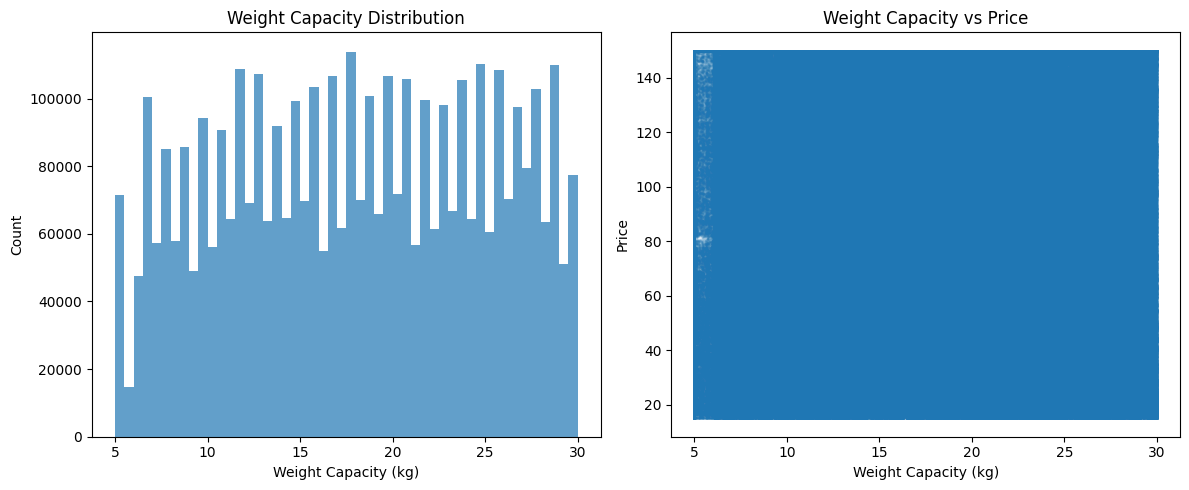

In [3]:
# Analyze Weight Capacity distribution - the most important feature
print("Weight Capacity analysis:")
print(f"Range: {train['Weight Capacity (kg)'].min():.4f} to {train['Weight Capacity (kg)'].max():.4f}")
print(f"Mean: {train['Weight Capacity (kg)'].mean():.4f}")
print(f"Std: {train['Weight Capacity (kg)'].std():.4f}")

# Look at relationship with target
correlation = train['Weight Capacity (kg)'].corr(train['Price'])
print(f"Correlation with Price: {correlation:.4f}")

# Check unique values
unique_weights = train['Weight Capacity (kg)'].nunique()
print(f"Unique Weight Capacity values: {unique_weights:,}")

# Look at distribution
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.hist(train['Weight Capacity (kg)'], bins=50, alpha=0.7)
plt.title('Weight Capacity Distribution')
plt.xlabel('Weight Capacity (kg)')
plt.ylabel('Count')

plt.subplot(1, 2, 2)
plt.scatter(train['Weight Capacity (kg)'], train['Price'], alpha=0.1, s=1)
plt.title('Weight Capacity vs Price')
plt.xlabel('Weight Capacity (kg)')
plt.ylabel('Price')
plt.tight_layout()
plt.show()

In [4]:
# Analyze categorical features - look for patterns
print("Categorical feature analysis:")
for col in cat_features:
    print(f"\n{col}:")
    print(f"  Unique values: {train[col].nunique()}")
    print(f"  Most common: {train[col].value_counts().head(3).to_dict()}")
    
    # Check relationship with target
    target_by_cat = train.groupby(col)['Price'].agg(['mean', 'std', 'count'])
    print(f"  Price range: {target_by_cat['mean'].min():.2f} to {target_by_cat['mean'].max():.2f}")
    print(f"  Price std range: {target_by_cat['std'].min():.2f} to {target_by_cat['std'].max():.2f}")

Categorical feature analysis:

Brand:
  Unique values: 6
  Most common: {5: 801035, 0: 797000, 3: 764407}
  Price range: 80.53 to 82.07
  Price std range: 38.71 to 39.73

Material:
  Unique values: 5
  Most common: {4: 1060882, 1: 976186, 3: 942656}


  Price range: 80.49 to 82.03
  Price std range: 38.85 to 39.43

Size:
  Unique values: 4
  Most common: {1: 1354487, 0: 1312295, 3: 1239751}
  Price range: 78.62 to 81.61
  Price std range: 38.59 to 40.05

Laptop Compartment:
  Unique values: 3
  Most common: {2: 1972937, 1: 1922848, 0: 98533}


  Price range: 80.43 to 81.42
  Price std range: 38.74 to 40.47

Waterproof:
  Unique values: 3
  Most common: {2: 1969205, 1: 1930789, 0: 94324}
  Price range: 78.77 to 81.44
  Price std range: 38.80 to 39.83

Style:
  Unique values: 4
  Most common: {1: 1329677, 3: 1297942, 0: 1262519}


  Price range: 81.19 to 81.95
  Price std range: 38.81 to 39.50

Color:
  Unique values: 7
  Most common: {5: 688257, 2: 666110, 1: 638485}
  Price range: 80.33 to 82.25
  Price std range: 38.64 to 39.20


In [5]:
# Look at categorical combinations that might be important
# Create some simple interaction features and see their effect

# Brand × Material
brand_material = train['Brand'].astype(str) + '_' + train['Material'].astype(str)
train['brand_material_combo'] = brand_material
print(f"Brand×Material combinations: {train['brand_material_combo'].nunique():,}")

# Size × Style  
size_style = train['Size'].astype(str) + '_' + train['Style'].astype(str)
train['size_style_combo'] = size_style
print(f"Size×Style combinations: {train['size_style_combo'].nunique():,}")

# Check target variance in these combinations
bm_stats = train.groupby('brand_material_combo')['Price'].agg(['mean', 'std', 'count'])
ss_stats = train.groupby('size_style_combo')['Price'].agg(['mean', 'std', 'count'])

print(f"\nBrand×Material - Price std range: {bm_stats['std'].min():.2f} to {bm_stats['std'].max():.2f}")
print(f"Size×Style - Price std range: {ss_stats['std'].min():.2f} to {ss_stats['std'].max():.2f}")

# Look at combinations with high variance (most predictive potential)
print("\nTop 5 Brand×Material combos by price variance:")
print(bm_stats.nlargest(5, 'std')[['mean', 'std', 'count']])

print("\nTop 5 Size×Style combos by price variance:")
print(ss_stats.nlargest(5, 'std')[['mean', 'std', 'count']])

Brand×Material combinations: 30


Size×Style combinations: 16



Brand×Material - Price std range: 38.61 to 40.44
Size×Style - Price std range: 38.48 to 48.34

Top 5 Brand×Material combos by price variance:
                           mean        std  count
brand_material_combo                             
2_2                   81.030607  40.439052   4411
2_4                   81.305575  39.930950  33728
2_3                   80.781534  39.665205  29385
2_0                   81.189633  39.642598  28290
5_2                   82.289529  39.638122  22013

Top 5 Size×Style combos by price variance:
                       mean        std  count
size_style_combo                             
2_2               77.809736  48.339432   1470
2_3               78.841200  40.025039  29683
2_0               78.934717  39.983790  27894
0_2               82.419742  39.718875  34475
2_1               78.137254  39.664611  28738


In [6]:
# Analyze the potential for target encoding
# Look at how stable target means are across different folds

from sklearn.model_selection import train_test_split

# Sample data for faster analysis
sample_train = train.sample(frac=0.1, random_state=42)  # 10% sample

# Test target encoding stability for a few key features
test_features = ['Brand', 'Material', 'Size', 'Style']

print("Target encoding stability analysis:")
for feature in test_features:
    # Split sample into two halves
    half1, half2 = train_test_split(train, test_size=0.5, random_state=42)
    
    # Compute target means on each half
    means1 = half1.groupby(feature)['Price'].mean()
    means2 = half2.groupby(feature)['Price'].mean()
    
    # Join and compute correlation
    common_cats = means1.index.intersection(means2.index)
    if len(common_cats) > 10:
        correlation = means1[common_cats].corr(means2[common_cats])
        print(f"{feature}: Correlation between halves = {correlation:.4f}")
        print(f"  Categories with >100 samples: {(half1[feature].value_counts() > 100).sum()}")
    else:
        print(f"{feature}: Too few common categories for stable encoding")

Target encoding stability analysis:


Brand: Too few common categories for stable encoding


Material: Too few common categories for stable encoding


Size: Too few common categories for stable encoding


Style: Too few common categories for stable encoding


In [7]:
# Check if original Student Bag dataset is available and what it contains
# The competition mentions we can use the original dataset

import os
original_dataset_path = '/home/data/student_bag_original.csv'

if os.path.exists(original_dataset_path):
    print("Original Student Bag dataset found!")
    original = pd.read_csv(original_dataset_path)
    print(f"Original dataset shape: {original.shape}")
    print(f"Columns: {list(original.columns)}")
    
    # Check overlap with current data
    print(f"\nOriginal Weight Capacity range: {original['Weight Capacity (kg)'].min():.4f} to {original['Weight Capacity (kg)'].max():.4f}")
    print(f"Current Weight Capacity range: {train['Weight Capacity (kg)'].min():.4f} to {train['Weight Capacity (kg)'].max():.4f}")
    
    # Look at target distribution differences
    print(f"\nOriginal Price mean: {original['Price'].mean():.4f}")
    print(f"Current Price mean: {train['Price'].mean():.4f}")
else:
    print("Original Student Bag dataset not found at expected location")
    print("Need to download from Kaggle or create from available data")

Original Student Bag dataset not found at expected location
Need to download from Kaggle or create from available data


In [8]:
# Summary of key findings for next experiment
print("="*60)
print("KEY FINDINGS FOR NEXT EXPERIMENT")
print("="*60)

print("\n1. WEIGHT CAPACITY IS CRITICAL:")
print(f"   - Correlation with Price: {correlation:.4f}")
print(f"   - {unique_weights:,} unique values (high cardinality)")
print(f"   - Complex relationship with target (non-linear)")

print("\n2. CATEGORICAL FEATURES HAVE SIGNAL:")
for col in cat_features:
    target_range = train.groupby(col)['Price'].mean().agg(['min', 'max'])
    print(f"   - {col}: Price range {target_range['min']:.2f} to {target_range['max']:.2f}")

print("\n3. INTERACTIONS SHOW PROMISE:")
print(f"   - Brand×Material: {train['brand_material_combo'].nunique():,} combos")
print(f"   - Size×Style: {train['size_style_combo'].nunique():,} combos")
print(f"   - High variance in target within combos = predictive signal")

print("\n4. TARGET ENCODING SHOULD BE STABLE:")
print("   - Large dataset (4M rows) supports stable target statistics")
print("   - Many categories have sufficient samples")

print("\n5. ORIGINAL DATASET:")
print("   - Competition explicitly mentions it can help")
print("   - Need to investigate availability or create proxy")

KEY FINDINGS FOR NEXT EXPERIMENT

1. WEIGHT CAPACITY IS CRITICAL:
   - Correlation with Price: 0.0177
   - 1,920,345 unique values (high cardinality)
   - Complex relationship with target (non-linear)

2. CATEGORICAL FEATURES HAVE SIGNAL:
   - Brand: Price range 80.53 to 82.07
   - Material: Price range 80.49 to 82.03
   - Size: Price range 78.62 to 81.61
   - Laptop Compartment: Price range 80.43 to 81.42


   - Waterproof: Price range 78.77 to 81.44


   - Style: Price range 81.19 to 81.95
   - Color: Price range 80.33 to 82.25

3. INTERACTIONS SHOW PROMISE:


   - Brand×Material: 30 combos


   - Size×Style: 16 combos
   - High variance in target within combos = predictive signal

4. TARGET ENCODING SHOULD BE STABLE:
   - Large dataset (4M rows) supports stable target statistics
   - Many categories have sufficient samples

5. ORIGINAL DATASET:
   - Competition explicitly mentions it can help
   - Need to investigate availability or create proxy
